In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import torchvision
import numpy as np
import torch
import cv2

from PIL import Image
from transform_factory import resize_322, center_crop_224, imagenet_normalize, tensorize, get_spatial_transform, get_color_transform
from torchvision import transforms
from expl import ExplFactory
from captum.attr import visualization as viz
from torchvision.models import resnet50, ResNet50_Weights
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
import os

In [3]:
def qhat(score, alpha:float):
    n = score.shape[0]
    q_hat = np.quantile(score, np.ceil((n+1) * (1-alpha)) / n, axis = 0)

    return q_hat

def conformality_score(true: np.ndarray, pred: np.ndarray, alpha: float):
    '''
    expls: [n_sample, 1, H, W] for Grad-CAM 
    '''
    assert true.shape == pred.shape

    n = pred.shape[0]

    score = np.abs(true - pred)
    q_hat = np.quantile(score, np.ceil((n+1) * (1-alpha)) / n, axis = 0)

    return q_hat

def get_conf_interval(expl: np.ndarray, q_hat: np.ndarray):
    high = expl + q_hat
    low = expl - q_hat
    return (low, high)

def calc_coverage_prob(true: np.ndarray, conf_low: np.ndarray, conf_high: np.ndarray):
    is_cover = np.logical_and(conf_low <= true, true <= conf_high)
    coverage_prob = np.sum(is_cover, axis = 0) / true.shape[0]

    return coverage_prob

def mismatch_rate(orig_expl, conf_high, conf_low):
    pos_mismatch = np.where(np.logical_and(orig_expl > 0, conf_low < 0))
    neg_mismatch = np.where(np.logical_and(orig_expl < 0, conf_high > 0))

    total_pixel = np.prod(orig_expl.shape)
    total_mismatch = len(pos_mismatch[0]) + len(neg_mismatch[0])
    # print(len(pos_mismatch[0]))
    # print(len(neg_mismatch[0]))
    return total_mismatch / total_pixel

def zero_contain_rate(conf_high, conf_low):
    zeros = np.zeros_like(conf_high)
    contain_zero = np.where(np.logical_and(zeros > conf_low, zeros < conf_high))

    return len(contain_zero[0]) / np.prod(zeros.shape[1:])

In [7]:
img_list = [ "n02100236_390.JPEG", "n01443537_605.JPEG", "n02100236_18.JPEG", "n01614925_13.JPEG", "ILSVRC2012_val_00015157.JPEG"]
# img_list = ["ILSVRC2012_val_00015157.JPEG"]

expl_methods = ["GradCAM", "Saliency", "InputXGrad", "IG"]
# expl_methods = ["LayerIG"]

for img in img_list:
    for expl_method in expl_methods:
        with open(f"results/20230205_pred_orig_eval_orig_transform_both_sign_all_reduction_sum/{img}_expl_{expl_method}_sample_20000_sigma_0.05_seed_0_orig_score.npy", "rb") as f:
            print(img, expl_method)
            orig_expl = np.load(f)
            true_expls = np.load(f)
            score = np.load(f)

            indicies = np.arange(0, score.shape[0], 1)
            for n_sample in [2000]:
                for n_sample_eval in [2000]:
                    results = []
                    np.random.shuffle(indicies)

                    cal_indicies, val_indicies = indicies[:n_sample], indicies[10000:10000+n_sample_eval]


                    for alpha in np.arange(0.05, 1, 0.05):            
                        # print(cal_indicies.shape)
                        q_hat = qhat(score[cal_indicies], alpha=alpha)
                        # print(q_hat.shape)

                        conf_low, conf_high = get_conf_interval(orig_expl, q_hat)
                        coverage_prob = calc_coverage_prob(true_expls[val_indicies], conf_low, conf_high)
                        zc_rate = zero_contain_rate(conf_high, conf_low)

                        # print(np.mean(coverage_prob))
                        results.append({
                            'img': img,
                            'expl_method': expl_method,
                            'alpha': alpha,
                            'coverage_prob': coverage_prob,
                            'zero_contain_rate': zc_rate,
                            'conf_high': conf_high,
                            'conf_low': conf_low
                        })

                    with open(f"results/20230205_pred_orig_eval_orig_transform_both_sign_all_reduction_sum/{img}_expl_{expl_method}_sample_{n_sample}_eval_sample_{n_sample_eval}_sigma_0.05_seed_0_results.npy", "wb") as f:
                        np.save(f, np.stack(results))
                    
                    print("Saved Results!")

n02100236_390.JPEG GradCAM
Saved Results!
n02100236_390.JPEG Saliency


KeyboardInterrupt: 

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

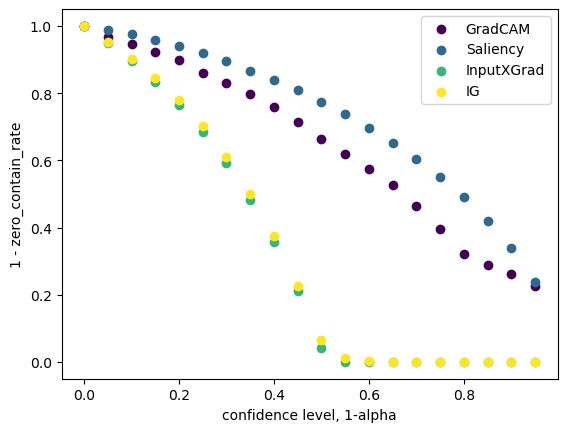

In [4]:
img = "ILSVRC2012_val_00015157.JPEG"
cmap = plt.get_cmap("viridis")
colors = cmap(np.linspace(0, 1, 4))
seed = 2
for expl_method, color in zip(["GradCAM", "Saliency", "InputXGrad", "IG"], colors):
    with open(f"results/20230205_pred_orig_eval_orig_transform_both_sign_all_reduction_sum/{img}_expl_{expl_method}_sample_20000_sigma_0.05_seed_0_results.npy", "rb") as f:
        results = np.load(f, allow_pickle=True)

    # print(results)
    for res in results:
        # print(1-res['alpha'], res['mismatch_rate'])
        plt.scatter(1 - res['alpha'], 1 - res['zero_contain_rate'], c=color)

    plt.scatter(0, 1, c=color, label=expl_method)

    plt.xlabel("confidence level, 1-alpha")
    plt.ylabel("1 - zero_contain_rate")
    
plt.legend()

In [59]:
orig_img_path = "/home/juhyeon/Imagenet/val/n01484850/ILSVRC2012_val_00015157.JPEG"
# orig_img_path = "/home/juhyeon/Imagenet/train/n01614925/n01614925_13.JPEG"
# orig_img_path = "/home/juhyeon/Imagenet/train/n01443537/n01443537_605.JPEG"
img = os.path.basename(orig_img_path)

orig_img = Image.open(orig_img_path)
orig_img

_orig_img = tensorize(center_crop_224(resize_322(orig_img))).unsqueeze(0).cuda()
_orig_img = np.transpose(_orig_img.squeeze().cpu().detach().numpy(), (1,2,0))

expl_method = "LayerIG"
with open(f"results/20230205_pred_orig_eval_orig_transform_both_sign_all_reduction_sum/{img}_expl_{expl_method}_sample_10000_eval_sample_10000_sigma_0.05_seed_0_results.npy", "rb") as f:
    results = np.load(f, allow_pickle=True)

with open(f"results/20230205_pred_orig_eval_orig_transform_both_sign_all_reduction_sum/{img}_expl_{expl_method}_sample_20000_sigma_0.05_seed_0_orig_score.npy", "rb") as f:
    print(img, expl_method)
    orig_expl = np.load(f)
    true_expls = np.load(f)
    score = np.load(f)


print("alpha: ", results[0]['alpha'])
conf_high, conf_low = results[0]['conf_high'], results[0]['conf_low']


fig, axes = plt.subplots(1, 3)

fig.suptitle(expl_method)

for i, ax in enumerate(axes.flat):
    if i == 0:
        im = ax.imshow(orig_expl.squeeze(0), cmap="seismic", vmin=-0.5, vmax=0.5)
    elif i == 1:
        im = ax.imshow(conf_high.squeeze(0), cmap='seismic',  vmin=-0.5, vmax=0.5)
    elif i == 2:
        im = ax.imshow(conf_low.squeeze(0), cmap='seismic',  vmin=-0.5, vmax=0.5)

cax, kw = mpl.colorbar.make_axes([ax for ax in axes.flat])
print(cax, kw)
# kw.update({'orientation':'horizontal', 'ticklocation':'top'})
fig.colorbar(im, cax=cax, **kw)
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'results/20230205_pred_orig_eval_orig_transform_both_sign_all_reduction_sum/ILSVRC2012_val_00015157.JPEG_expl_LayerIG_sample_10000_eval_sample_10000_sigma_0.05_seed_0_results.npy'

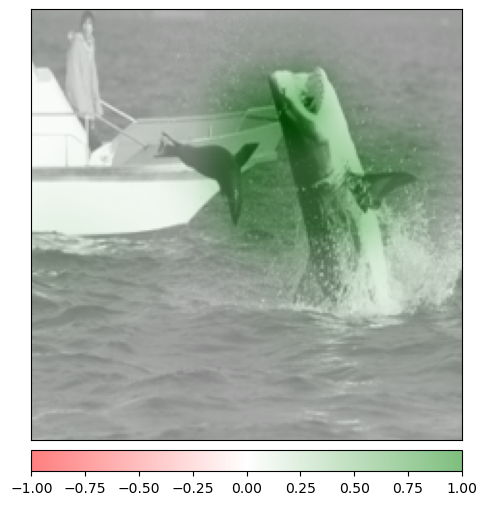

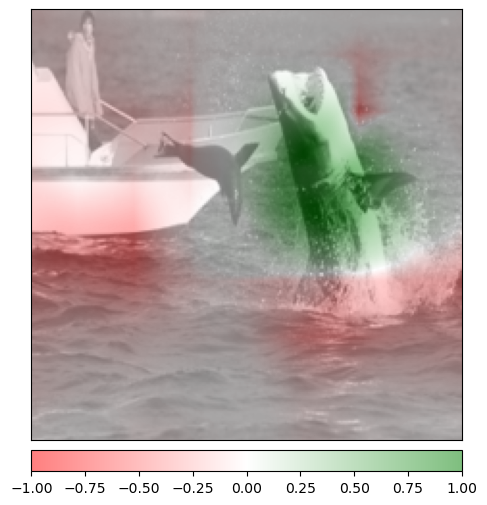

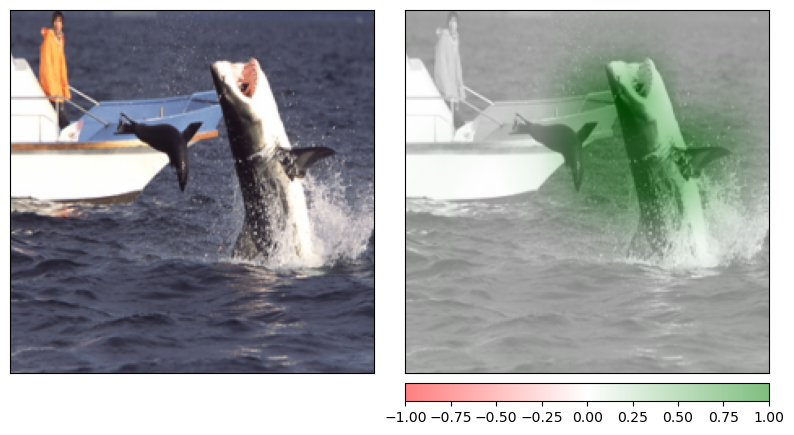

In [60]:
_ = viz.visualize_image_attr(np.transpose(conf_high, (1,2,0)), _orig_img, method="blended_heat_map", sign="all", show_colorbar=True)
_ = viz.visualize_image_attr(np.transpose(conf_low, (1,2,0)), _orig_img, method="blended_heat_map", sign="all", show_colorbar=True)

_ = viz.visualize_image_attr_multiple(np.transpose(orig_expl, (1,2,0)), _orig_img, methods=['original_image', 'blended_heat_map'], signs=['all', 'all'], show_colorbar=True)